[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1XYcTXRNG30QvIhHPytzUl1QbZ44-aJJ4?usp=sharing)

# <a name="optimal-portfolio-with-denoised-covariance"></a>Optimal Portfolio With Denoised Covariance
This notebook demonstrates a method for constructing an optimal investment portfolio by employing techniques to denoise the estimated covariance matrix of asset returns. It addresses the challenge of estimating accurate covariance matrices, which is crucial for modern portfolio theory but can be susceptible to noise from limited historical data. The approach involves using concepts from random matrix theory, specifically the Marchenko-Pastur distribution, to identify and separate the "signal" from the "noise" in the eigenvalues of the asset correlation matrix. By applying a denoising procedure, a more robust covariance matrix is obtained. This denoised covariance matrix is then used within the Markowitz mean-variance optimization framework to determine the portfolio weights that maximize the Sharpe ratio. The performance of the resulting optimal portfolio is then evaluated and compared against a benchmark index.

**Table of Contents**

*   [Optimal Portfolio With Denoised Covariance](#optimal-portfolio-with-denoised-covariance)
*   [Basic Preparation](#basic-preparation)
*   [Data Download](#data-download)
*   [Estimated Covariance Matrix](#estimated-covariance-matrix)
*   [Denoising](#denoising)
*   [Markowitz Optimization](#markowitz-optimization)
*   [Compare with the Index (Benchmark)](#compare-with-the-index-benchmark)

# <a name="basic-preparation"></a>Basic Preparation

In [1]:
%%capture
try:
    from pypfopt import risk_models
except:
    !pip install PyPortfolioOpt
    !pip install --upgrade yfinance
finally:
    import pandas as pd
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    import seaborn as sns
    import yfinance as yf
    import random
    from pypfopt import EfficientFrontier, risk_models, BlackLittermanModel, plotting, expected_returns, black_litterman, objective_functions
    import pypfopt
    import statsmodels.formula.api as sm
    import statsmodels
    from scipy.stats import trim_mean, gaussian_kde
    from scipy.optimize import minimize
    from scipy.linalg import block_diag
    from scipy.cluster.hierarchy import linkage
    from scipy.spatial.distance import pdist
    import cvxpy as cvx
    from datetime import datetime, timedelta
    import itertools
    import ipywidgets as widgets
    from IPython.display import display
    from sklearn.cluster import KMeans
    from sklearn.neighbors import KernelDensity
    from sklearn.covariance import LedoitWolf
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import silhouette_samples, silhouette_score
    from sklearn.utils import check_random_state

    import warnings
    warnings.filterwarnings('ignore')

# <a name="data-download"></a>Data Download
This section handles the process of obtaining historical price data for a selected group of assets. It begins by fetching a list of S&P 500 company tickers and then randomly selects a specified number of these tickers to form the portfolio. Using the yfinance library, the code downloads the closing price data for the chosen assets over a defined training period. Additionally, it downloads the S&P 500 index data for a subsequent testing period to serve as a benchmark for performance comparison. The downloaded data is then organized into pandas DataFrames for further analysis, and daily returns are calculated for both the training and testing datasets.

In [2]:
def obtain_random_tickers(number, seed=None):
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    tables = pd.read_html(url)
    sp500_table = tables[0]
    tickers = sp500_table['Symbol'].tolist()
    # Ensure we don't request more than available tickers
    if number > len(tickers):
        raise ValueError("Requested number exceeds available tickers.")
    if seed is not None:
        random.seed(seed)
    return random.sample(tickers, number)

#assets = ['AAPL','MSFT',"GOOG",'JPM','JNJ','XOM','KO']
assets = obtain_random_tickers(10)
print(f'\nTickers to be used are :{assets}')
start_date = '2020-01-01'
months = 6
end_date_for_training = (pd.to_datetime(start_date) + pd.DateOffset(months=months)).strftime('%Y-%m-%d')
end_date_for_testing = (pd.to_datetime(start_date) + pd.DateOffset(months=months+6)).strftime('%Y-%m-%d')

data_df_training = yf.download(assets, start=start_date, end=end_date_for_training).dropna(axis =1)
data_df_testing = yf.download(assets, start=end_date_for_training, end=end_date_for_testing).dropna(axis =1)
print(f"\nThe training set of data start from {start_date} to {end_date_for_training}")
print(f"The testing set of data start from {end_date_for_training} to {end_date_for_testing}")

# 5. Download S&P 500 data and calculate benchmark cumulative returns
sp500_ticker = '^GSPC'
sp500_data = yf.download(sp500_ticker, start=end_date_for_training, end=end_date_for_testing)['Close'].dropna()
sp500_daily_returns = sp500_data.pct_change().dropna()
sp500_cumulative_returns = (1 + sp500_daily_returns).cumprod()


Tickers to be used are :['STT', 'BR', 'NVDA', 'RVTY', 'WAB', 'CPRT', 'TSN', 'FICO', 'MPWR', 'ROK']


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


The training set of data start from 2020-01-01 to 2020-07-01
The testing set of data start from 2020-07-01 to 2021-01-01


Let's see the daily return below

In [3]:
assets_daily_return_training = data_df_training.copy()['Close'].pct_change().dropna()
assets_daily_return_testing = data_df_testing.copy()['Close'].pct_change().dropna()
assets_daily_return_training

Ticker,BR,CPRT,FICO,MPWR,NVDA,ROK,RVTY,STT,TSN,WAB
Date,,,,,,,,,,
2020-01-03,0.000808,-0.008772,-0.002612,-0.018110,-0.016006,-0.014589,-0.018916,-0.014735,0.006780,-0.007659
2020-01-06,0.009041,0.008957,0.005446,-0.010240,0.004194,0.007945,0.010414,0.015332,-0.004747,-0.004108
2020-01-07,-0.003520,-0.001284,0.011693,0.009317,0.012107,-0.002056,0.008163,0.013863,-0.014532,-0.000375
2020-01-08,0.006423,0.006854,0.007310,-0.001303,0.001876,0.007604,-0.002126,-0.005127,0.006191,-0.017131
2020-01-09,0.021857,0.013616,0.026014,0.013497,0.010982,0.008716,0.012882,0.017548,-0.002014,-0.001781
...,...,...,...,...,...,...,...,...,...,...
2020-06-24,-0.015644,-0.038093,-0.038705,-0.028749,-0.022698,-0.017538,-0.032560,-0.047303,-0.028123,-0.051570
2020-06-25,0.017033,0.002337,0.017870,0.039331,0.027557,0.015461,-0.000417,0.041052,0.007234,-0.003774
2020-06-26,-0.001202,-0.023067,-0.024425,-0.010193,-0.035300,-0.014073,-0.020849,-0.056577,-0.026558,-0.038395


# <a name="estimated-covariance-matrix"></a>Estimated Covariance Matrix
This section focuses on calculating the sample covariance matrix of the assets' daily returns during the training period. The covariance matrix is a fundamental input for portfolio optimization, as it quantifies the relationships and co-movements between the different assets. The code utilizes the pypfopt library's risk_matrix function to compute the sample covariance matrix directly from the asset price data. It also shows the calculation of the covariance matrix from the daily returns DataFrame as a comparison.

In [4]:
sample_cov = pypfopt.risk_models.risk_matrix(data_df_training.Close, method='sample_cov')
assets_daily_return_training.cov()

Ticker,BR,CPRT,FICO,MPWR,NVDA,ROK,RVTY,STT,TSN,WAB
Ticker,,,,,,,,,,
BR,0.000882,0.000714,0.000837,0.000978,0.000810,0.000844,0.000543,0.000929,0.000291,0.000804
CPRT,0.000714,0.001328,0.001277,0.001273,0.001087,0.001131,0.000570,0.001152,0.000765,0.001080
FICO,0.000837,0.001277,0.002321,0.001861,0.001684,0.001491,0.000890,0.001576,0.001147,0.001520
MPWR,0.000978,0.001273,0.001861,0.002377,0.001794,0.001430,0.000851,0.001712,0.001071,0.001518
NVDA,0.000810,0.001087,0.001684,0.001794,0.001974,0.001205,0.000806,0.001399,0.000876,0.001098
ROK,0.000844,0.001131,0.001491,0.001430,0.001205,0.001692,0.000723,0.001495,0.000901,0.001406
RVTY,0.000543,0.000570,0.000890,0.000851,0.000806,0.000723,0.000739,0.000876,0.000469,0.000732
STT,0.000929,0.001152,0.001576,0.001712,0.001399,0.001495,0.000876,0.002217,0.001086,0.001486
TSN,0.000291,0.000765,0.001147,0.001071,0.000876,0.000901,0.000469,0.001086,0.001629,0.001081


# <a name="denoising"></a>Denoising
This section implements techniques to "denoise" the estimated covariance matrix. Sample covariance matrices can be noisy, especially when dealing with a limited number of observations relative to the number of assets. Denoising methods aim to improve the accuracy and stability of the covariance estimate. This involves applying the Marchenko-Pastur distribution to identify and remove noise from the eigenvalues of the correlation matrix derived from the sample covariance matrix. The code defines several functions to facilitate this process, including calculating the Marchenko-Pastur probability density function, performing Principal Component Analysis (PCA), fitting kernel density estimates, and transforming between covariance and correlation matrices. The denoised correlation matrix is then used to reconstruct a denoised covariance matrix.

In [5]:
# Denoising
# This section implements techniques to "denoise" the estimated covariance matrix. Sample covariance matrices can be noisy, especially when dealing with a limited number of observations relative to the number of assets. Denoising methods aim to improve the accuracy and stability of the covariance estimate. This involves applying the Marchenko-Pastur distribution to identify and remove noise from the eigenvalues of the correlation matrix derived from the sample covariance matrix. The code defines several functions to facilitate this process, including calculating the Marchenko-Pastur probability density function, performing Principal Component Analysis (PCA), fitting kernel density estimates, and transforming between covariance and correlation matrices. The denoised correlation matrix is then used to reconstruct a denoised covariance matrix.

def marchenkoPasturPDF(variance, ratio, points):
    eig_min, eig_max = variance*(1-(1./ratio)**.5)**2, variance*(1+(1./ratio)**.5)**2
    eig_values = np.linspace(eig_min, eig_max, points)

    density = ratio/(2*np.pi*variance*eig_values)*((eig_max-eig_values)*(eig_values-eig_min))**.5
    density = pd.Series(density, index=eig_values)
    return density

def computePCA(matrix):
    eigenvals, eigenvecs = np.linalg.eig(matrix)
    sorted_indices = eigenvals.argsort()[::-1]

    eigenvals, eigenvecs = eigenvals[sorted_indices], eigenvecs[:, sorted_indices]

    return eigenvals, eigenvecs

def estimateKDE(observations, bandwidth=.15, kernel_type='gaussian', grid_points=None):
    if len(observations.shape) == 1:
        observations = observations.reshape(-1,1)
    else:
        pass
    kde_model = KernelDensity(kernel=kernel_type, bandwidth=bandwidth).fit(observations)
    if grid_points is None:
        grid_points = np.unique(observations).reshape(-1,1)
    elif len(grid_points.shape) == 1:
        grid_points = grid_points.reshape(-1,1)

    log_prob = kde_model.score_samples(grid_points)
    pdf_estimate = pd.Series(np.exp(log_prob), index=grid_points.flatten())
    return pdf_estimate

def generateRandomCovariance(num_cols, num_factors):
    weights = np.random.normal(size=(num_cols, num_factors))
    covariance = np.dot(weights, weights.T)
    covariance += np.diag(np.random.uniform(size=num_cols))
    return covariance

def covarianceToCorrelation(covariance):

    std_devs = np.sqrt(np.diag(covariance))
    correlation = covariance / np.outer(std_devs, std_devs)
    correlation[correlation < -1], correlation[correlation > 1] = -1, 1
    return correlation

def correlationToCovariance(correlation, std_devs):
    covariance = correlation * np.outer(std_devs, std_devs)
    return covariance

def calculateErrorPDFs(variance, eigenvalues_1d, ratio, bandwidth, points=1000):
    variance = variance[0]
    theoretical_pdf = marchenkoPasturPDF(variance, ratio, points)
    empirical_pdf = estimateKDE(eigenvalues_1d, bandwidth, grid_points=theoretical_pdf.index.values)
    sum_squared_error = np.sum((empirical_pdf - theoretical_pdf)**2)
    #print("Sum of Squared Errors:"+str(sum_squared_error))
    return sum_squared_error

def optimizeVariance(eigenvalues_1d, ratio, bandwidth):
    optimization_result = minimize(lambda *args: calculateErrorPDFs(*args), x0=np.array(0.5),
                                   args=(eigenvalues_1d, ratio, bandwidth),
                                   bounds=((1E-5, 1-1E-5),))
    #print("Found errPDFs: "+str(optimization_result['x'][0]))
    if optimization_result['success']:
        variance = optimization_result['x'][0]
    else:
        variance = 1
    eig_max = variance*(1+(1./ratio)**.5)**2
    return eig_max, variance

def getDenoisedCorrelation(eigenvalues_1d, eigenvectors, num_factors):
    eigenvalues_modified = eigenvalues_1d.copy()
    eigenvalues_modified[num_factors:] = eigenvalues_modified[num_factors:].sum() / float(eigenvalues_modified.shape[0] - num_factors)
    eigenvalues_diag_matrix = np.diagflat(eigenvalues_modified)
    corr_denoised = np.dot(eigenvectors, eigenvalues_diag_matrix).dot(eigenvectors.T)
    corr_denoised = covarianceToCorrelation(corr_denoised)
    return corr_denoised

def removeMarketComponent(correlation_matrix, eigenvalues_1d, eigenvectors, market_factor_count=1):
    eigenvalues_diag_matrix = np.diagflat(eigenvalues_1d)
    market_eigenvalues = eigenvalues_diag_matrix[:market_factor_count, :market_factor_count]
    market_eigenvectors = eigenvectors[:, :market_factor_count]
    market_correlation = np.dot(market_eigenvectors, market_eigenvalues).dot(market_eigenvectors.T)
    residual_correlation = correlation_matrix - market_correlation
    residual_correlation = covarianceToCorrelation(residual_correlation)
    return residual_correlation

corr_sample = covarianceToCorrelation(sample_cov)

eigvals_1d, eigvecs = computePCA(corr_sample)

time_length = len(data_df_training.Close)
num_assets = len(assets)
aspect_ratio = time_length / num_assets

max_eigenval, variance_fit = optimizeVariance(eigvals_1d, aspect_ratio, 0.01)

num_factors = eigvals_1d.shape[0] - eigvals_1d[::-1].searchsorted(max_eigenval)
print(f"Number of factors (signal eigenvalues): {num_factors}")

Number of factors (signal eigenvalues): 2


In [6]:
# denoisedCorr now expects 1D eigenvalues and 2D eigenvectors, and the number of factors
denoised_correlation_matrix = getDenoisedCorrelation(eigvals_1d, eigvecs, num_factors)

denoised_correlation_df = pd.DataFrame(denoised_correlation_matrix,
                                      index=assets,
                                      columns=assets)
# Now you can work with denoised_correlation_matrix
print("\nDenoised Correlation Matrix:")
denoised_correlation_df


Denoised Correlation Matrix:


,STT,BR,NVDA,RVTY,WAB,CPRT,TSN,FICO,MPWR,ROK
STT,1.000000,0.638360,0.612396,0.652507,0.659441,0.644402,0.686601,0.635834,0.259719,0.583913
BR,0.638360,1.000000,0.715590,0.719610,0.706622,0.718023,0.685959,0.714211,0.532099,0.705337
NVDA,0.612396,0.715590,1.000000,0.726251,0.709079,0.726098,0.678258,0.723360,0.585391,0.723933
RVTY,0.652507,0.719610,0.726251,1.000000,0.718566,0.729495,0.698755,0.725488,0.534965,0.715336
WAB,0.659441,0.706622,0.709079,0.718566,1.000000,0.715981,0.694657,0.711407,0.497902,0.695963
CPRT,0.644402,0.718023,0.726098,0.729495,0.715981,1.000000,0.694180,0.724240,0.543550,0.716061
TSN,0.686601,0.685959,0.678258,0.698755,0.694657,0.694180,1.000000,0.688153,0.415313,0.659572
FICO,0.635834,0.714211,0.723360,0.725488,0.711407,0.724240,0.688153,1.000000,0.548202,0.714036
MPWR,0.259719,0.532099,0.585391,0.534965,0.497902,0.543550,0.415313,0.548202,1.000000,0.605873
ROK,0.583913,0.705337,0.723933,0.715336,0.695963,0.716061,0.659572,0.714036,0.605873,1.000000


In [7]:
original_returns = data_df_training.copy()['Close'].pct_change().dropna()
original_std_dev = original_returns.std()

denoised_covariance_matrix_np = correlationToCovariance(denoised_correlation_matrix, original_std_dev.values)
denoised_covariance_df = pd.DataFrame(denoised_covariance_matrix_np,
                                      index=assets,
                                      columns=assets)
print("\nDenoised Covariance Matrix:")
denoised_covariance_df


Denoised Covariance Matrix:


,STT,BR,NVDA,RVTY,WAB,CPRT,TSN,FICO,MPWR,ROK
STT,0.000882,0.000691,0.000876,0.000944,0.000870,0.000787,0.000554,0.000889,0.000311,0.000745
BR,0.000691,0.001328,0.001256,0.001278,0.001144,0.001076,0.000679,0.001226,0.000783,0.001104
NVDA,0.000876,0.001256,0.002321,0.001706,0.001518,0.001439,0.000888,0.001641,0.001138,0.001499
RVTY,0.000944,0.001278,0.001706,0.002377,0.001556,0.001463,0.000926,0.001665,0.001052,0.001498
WAB,0.000870,0.001144,0.001518,0.001556,0.001974,0.001308,0.000839,0.001488,0.000893,0.001329
CPRT,0.000787,0.001076,0.001439,0.001463,0.001308,0.001692,0.000776,0.001403,0.000902,0.001265
TSN,0.000554,0.000679,0.000888,0.000926,0.000839,0.000776,0.000739,0.000881,0.000455,0.000770
FICO,0.000889,0.001226,0.001641,0.001665,0.001488,0.001403,0.000881,0.002217,0.001042,0.001445
MPWR,0.000311,0.000783,0.001138,0.001052,0.000893,0.000902,0.000455,0.001042,0.001629,0.001051
ROK,0.000745,0.001104,0.001499,0.001498,0.001329,0.001265,0.000770,0.001445,0.001051,0.001846


# <a name="markowitz-optimization"></a>Markowitz Optimization
This section applies the principles of Markowitz's modern portfolio theory to determine an optimal asset allocation. Using the denoised covariance matrix and expected returns (calculated as the historical mean returns from the training data), the code constructs an EfficientFrontier object from the pypfopt library. A constraint is added to limit the maximum weight of any single asset. The optimizer then calculates the portfolio weights that maximize the Sharpe ratio, a measure of risk-adjusted return. The resulting optimized weights are then cleaned and printed, along with the expected performance metrics of the optimized portfolio.

In [8]:
# 2. Calculate expected returns (using historical mean returns)
mu = expected_returns.mean_historical_return(data_df_training['Close'])

# 3. Run the Markowitz optimizer (mean-variance optimization)
ef = EfficientFrontier(mu, denoised_covariance_df)
ef.add_constraint(lambda w: w <= 0.4)
raw_weights = ef.max_sharpe()  # Or ef.min_volatility()
cleaned_weights = ef.clean_weights()

# 4. Print the optimized weights
print("Optimized Portfolio Weights:")
for asset, weight in cleaned_weights.items():
    print(f"{asset}: {weight:.3f}")
performance = ef.portfolio_performance(verbose=True)

Optimized Portfolio Weights:
BR: 0.200
CPRT: 0.000
FICO: 0.000
MPWR: 0.400
NVDA: 0.400
ROK: 0.000
RVTY: 0.000
STT: 0.000
TSN: 0.000
WAB: 0.000
Expected annual return: 94.0%
Annual volatility: 3.9%
Sharpe Ratio: 24.10


# <a name="compare-with-the-index-benchmark"></a>Compare with the Index (Benchmark)
This section evaluates the performance of the optimized portfolio against a benchmark, the S&P 500 index, using the data from the testing period. It first identifies the assets with non-zero weights in the optimized portfolio and extracts their price data for the testing period. The daily returns of the optimized portfolio are calculated by weighting the individual asset returns by their respective optimized weights. Cumulative returns are then computed for both the optimized portfolio and the S&P 500 index. Finally, a plot is generated to visually compare the cumulative return trajectories of the optimized portfolio, the individual assets (both those in the portfolio and those not), and the S&P 500 benchmark over the testing period.

The portfolio will be made up of 0.200 BR, 0.400 MPWR, 0.400 NVDA.
The final cumulative return of the portfolio from 2020-07-01 to 2021-01-01 is: 1.4238


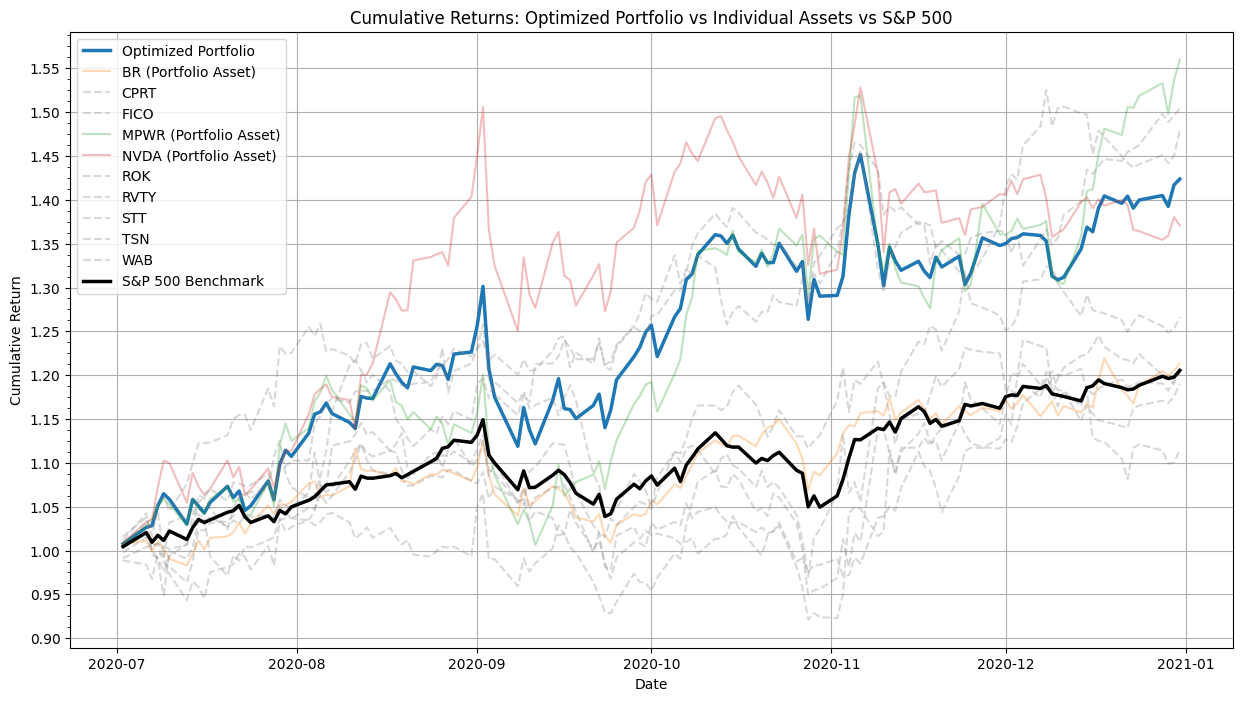

In [9]:
# 1. Filter assets with non-zero weights
non_zero_weights = {asset: w for asset, w in cleaned_weights.items() if w > 0}
# Create the string parts for each asset
parts = [f"{weight:.3f} {asset}" for asset, weight in non_zero_weights.items()]
# Join them with commas
portfolio_str = ", ".join(parts)
print(f"The portfolio will be made up of {portfolio_str}.")

# 2. Extract price data for those assets
price_data_optimized = data_df_testing['Close'][list(non_zero_weights.keys())]

# 3. Calculate portfolio daily returns:
# First compute daily returns of each asset
daily_returns_optimized = price_data_optimized.pct_change().dropna()

# Multiply each asset's returns by its weight and sum to get portfolio returns
weights_array = np.array(list(non_zero_weights.values()))
portfolio_returns = daily_returns_optimized.dot(weights_array)

# 4. Calculate cumulative returns (assuming starting at 1)
cumulative_returns_optimized = (1 + portfolio_returns).cumprod()
final_value = cumulative_returns_optimized.iloc[-1]
print(f"The final cumulative return of the portfolio from {end_date_for_training} to {end_date_for_testing} is: {final_value:.4f}")

# 5. Plot cumulative returns
plt.figure(figsize=(15,8))

# Plot optimized portfolio cumulative returns (with default color)
plt.plot(cumulative_returns_optimized, label='Optimized Portfolio',linewidth=2.5)

# Get cumulative returns for all assets
all_assets_price_data = data_df_testing['Close']
all_assets_daily_returns = all_assets_price_data.pct_change().dropna()
all_assets_cumulative_returns = (1 + all_assets_daily_returns).cumprod()

# Plot individual asset cumulative returns
for asset in all_assets_cumulative_returns.columns:
    if asset in non_zero_weights:
        # Plot assets in the portfolio with a different color (e.g., a lighter shade of the default portfolio color or a specific color)
        plt.plot(all_assets_cumulative_returns[asset], label=f'{asset} (Portfolio Asset)', linestyle='-', alpha = 0.3) # Default color
    else:
        # Plot assets not in the portfolio in gray
        plt.plot(all_assets_cumulative_returns[asset], label=asset, linestyle='--', color='gray', alpha = 0.3)


# Plot S&P 500 benchmark
plt.plot(sp500_cumulative_returns, label='S&P 500 Benchmark', color='black', linestyle='-', linewidth=2.5) # Using black and solid line for benchmark


plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns: Optimized Portfolio vs Individual Assets vs S&P 500')
plt.legend()
plt.grid(True)
# Increase y-axis ticks/bins
ax = plt.gca()  # get current axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))  # set major ticks every 0.1 (adjust as needed)
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))   # add minor ticks between majors
plt.show()